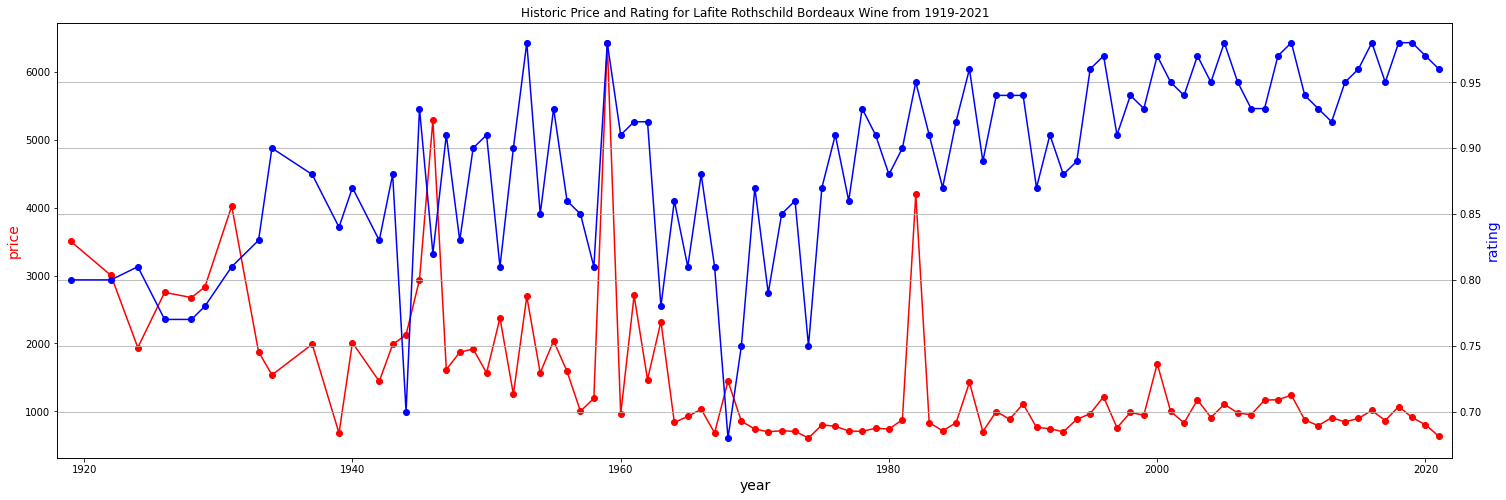

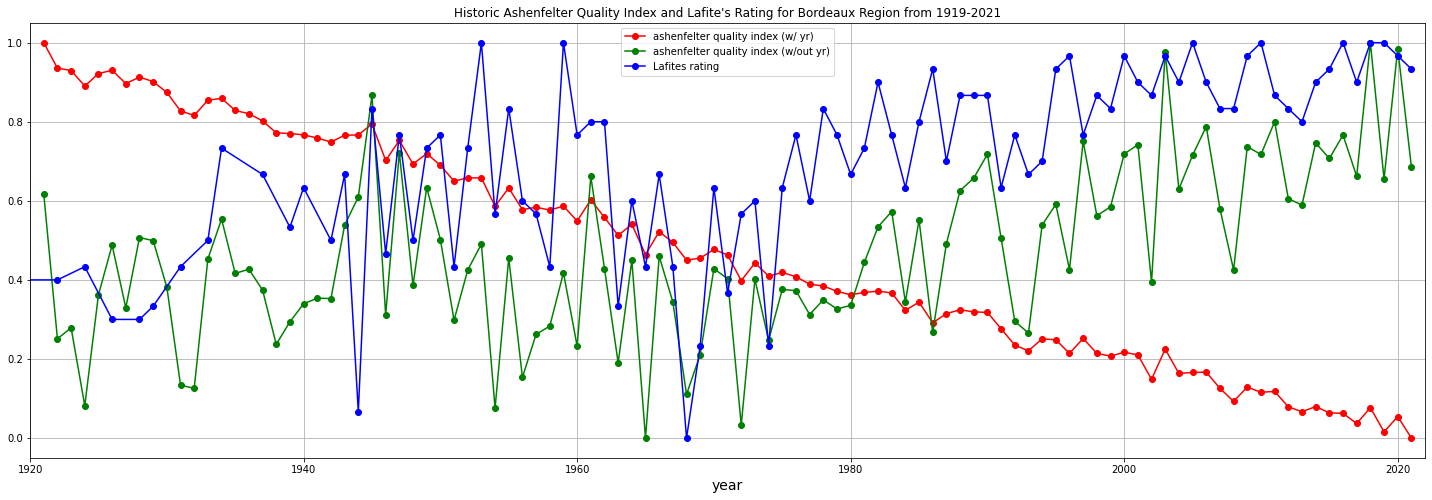

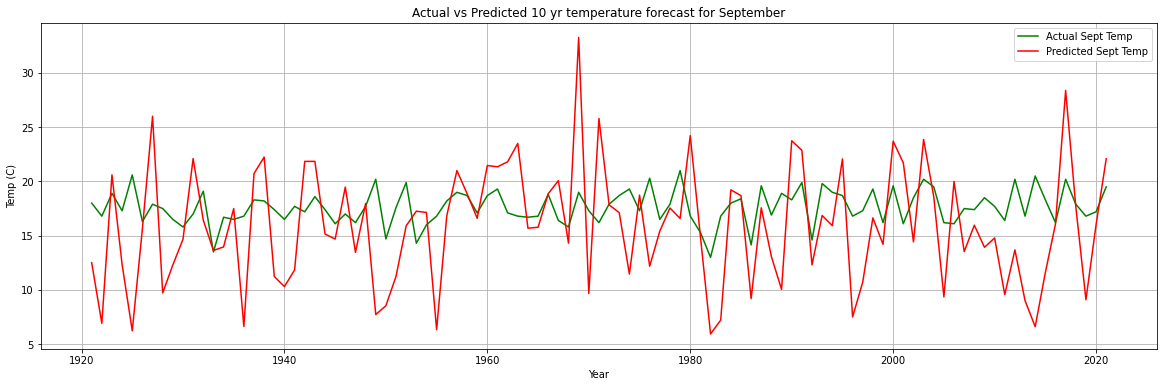

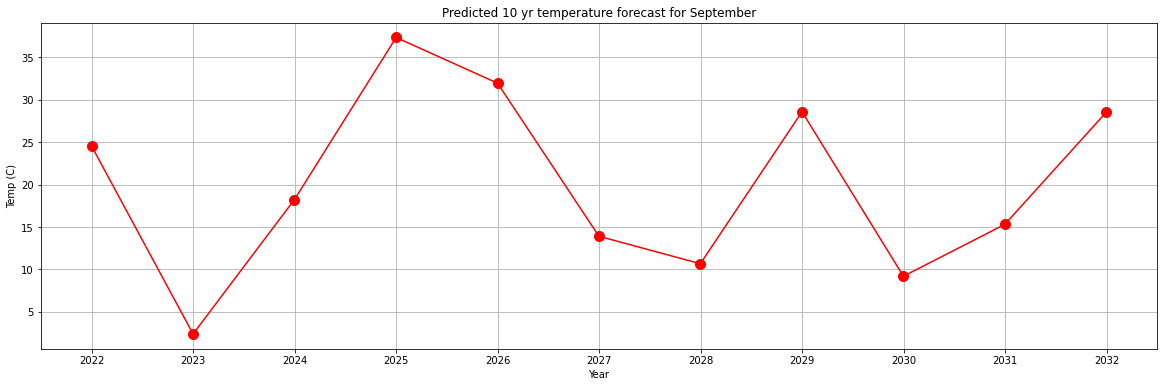

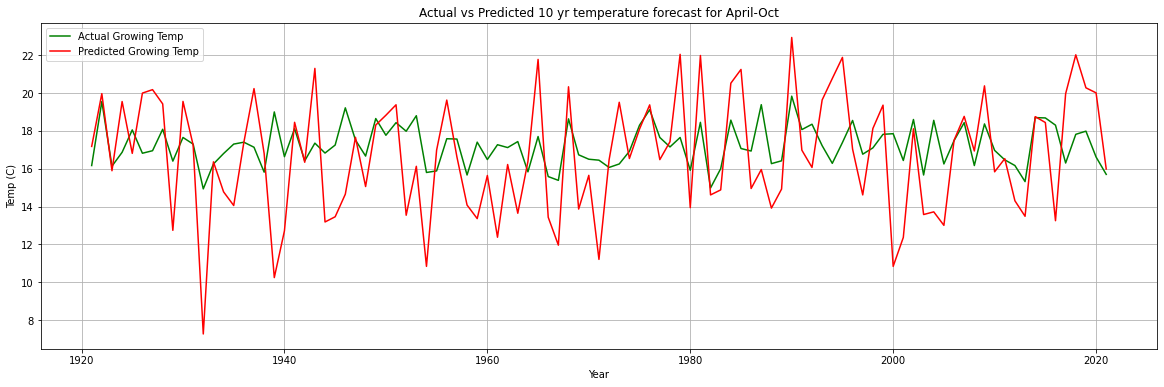

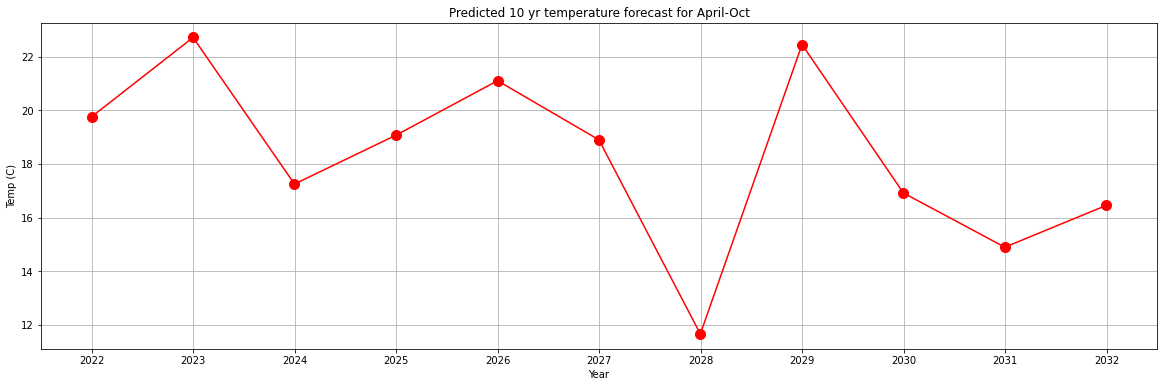

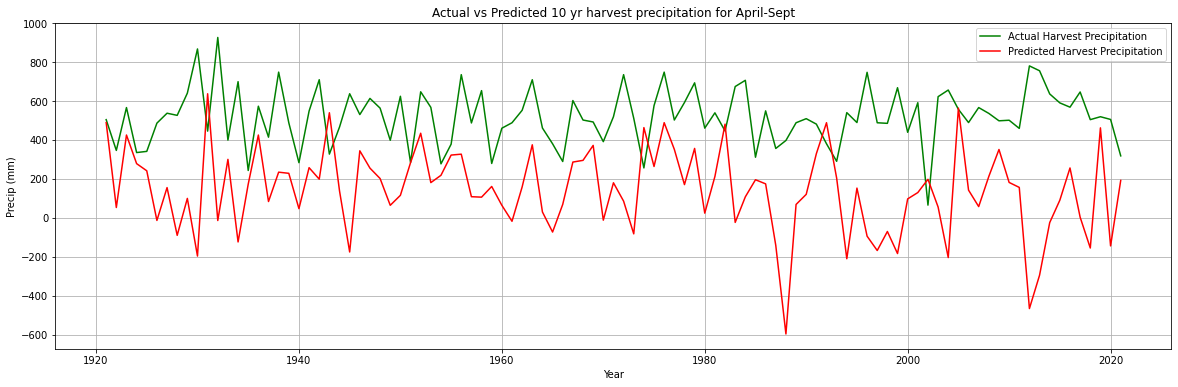

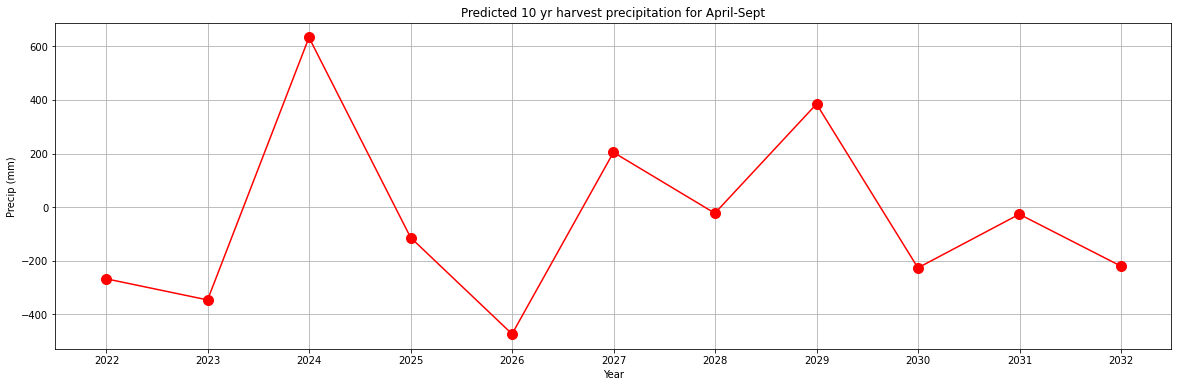

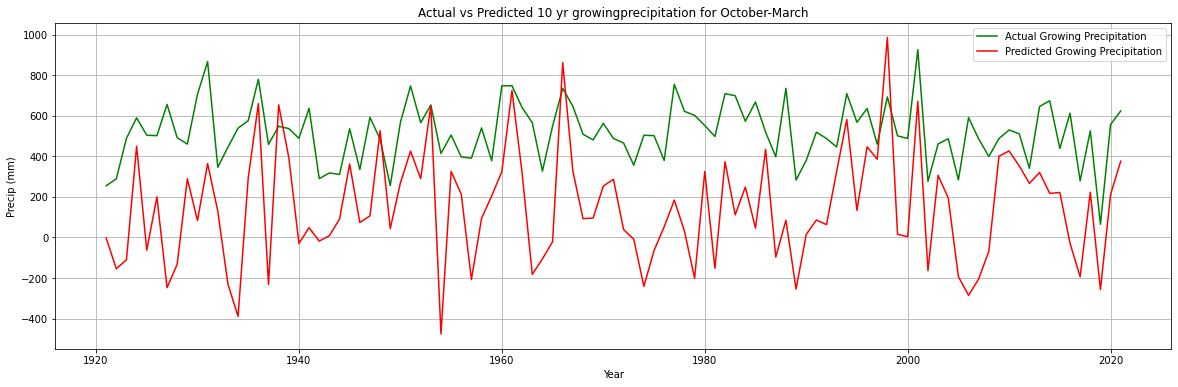

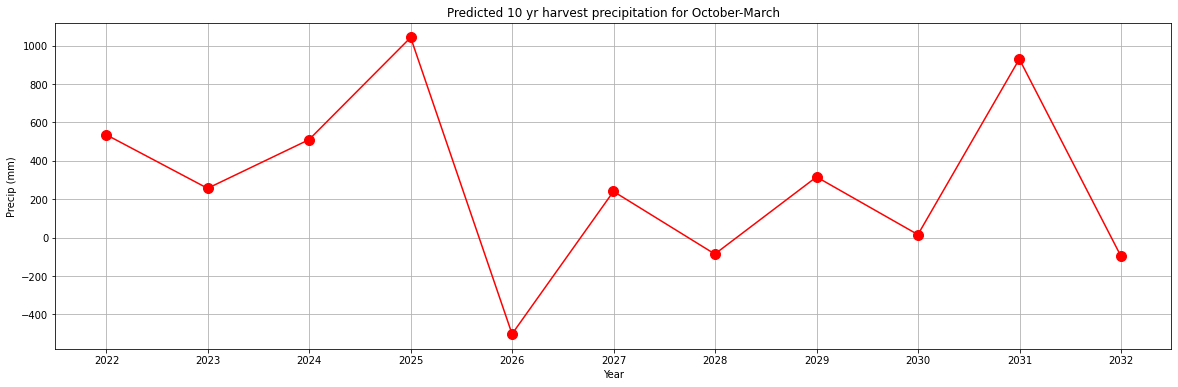

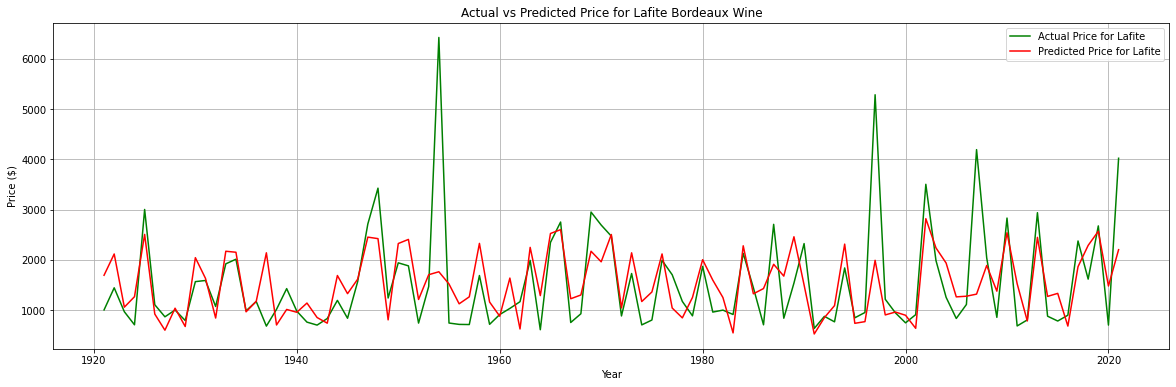

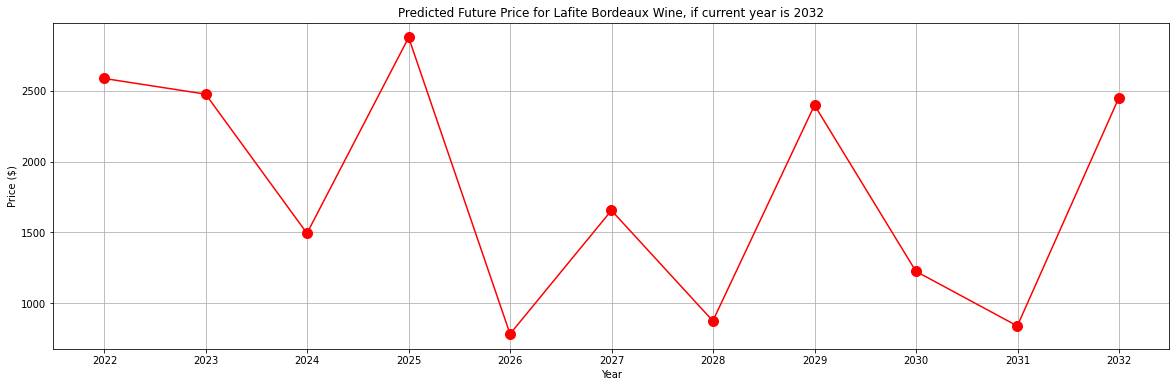

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics as stat
import random

def ashenfelterQualityIndex2(avgTempGrowing, 
                            totalPrecipAug,
                            avgTempSept, 
                            totalPrecipWinter):
    return (.608*(avgTempGrowing) - .00380*(totalPrecipAug) + .00115*(totalPrecipWinter) + .00765*(avgTempSept))

def ashenfelterQualityIndex1(vintageYr,
                            avgTempGrowing, 
                            totalPrecipAug,
                            avgTempSept, 
                            totalPrecipWinter):

    return (.240*(2021-vintageYr) + .608*(avgTempGrowing) - .00380*(totalPrecipAug) + .00115*(totalPrecipWinter) + .00765*(avgTempSept))

def ashenfelterQualityIndex3(vintageYr,
                            avgTempGrowing, 
                            totalPrecipAug,
                            avgTempSept, 
                            totalPrecipWinter):

    return (.240*(2032-vintageYr) + .608*(avgTempGrowing) - .00380*(totalPrecipAug) + .00115*(totalPrecipWinter) + .00765*(avgTempSept))



df1 = pd.read_excel(r'C:/Users/polin/Dropbox/EE 608 spring 2023/project/Wine-Quality-Modeling/data/lafitePriceQuality.xlsx')
df1 = df1.iloc[::2]
Year = df1['year'].values
Price = df1['price'].values
Quality = df1['quality'].values
Index = []
for num in Quality:
    q = num.split('/') 
    Index.append(float(q[0])/float(q[1]))
fig,ax = plt.subplots()
fig.set_size_inches(25, 8)
ax.plot(Year, Price, color="red", marker="o")
ax.set_xlabel("year", fontsize = 14)
ax.set_ylabel("price", color="red", fontsize=14)
ax2 = ax.twinx()
ax2.plot(Year, Index,color="blue", marker="o")
ax2.set_ylabel("rating", color="blue", fontsize=14)
plt.xlim(1918, 2022)
plt.title("Historic Price and Rating for Lafite Rothschild Bordeaux Wine from 1919-2021")
plt.grid()
plt.show()

df2 = pd.read_excel(r'C:/Users/polin/Dropbox/EE 608 spring 2023/project/Wine-Quality-Modeling/data/bordeauxWeather.xlsx')
Year2 = df2['year'].values.tolist()
avgTempSept = df2['sepT'].values.tolist()
avgTempGrowing = df2['avgTempAprilSeptember'].values.tolist()
totalPrecipAug = df2['totalPSeptAug'].values.tolist()
totalPrecipWinter = df2['totalPOctMar'].values.tolist()
ashIndex1 = []
for idx, y in enumerate(Year2):
        ashIndex1.append(ashenfelterQualityIndex1(y, 
                                            avgTempGrowing[idx], 
                                            totalPrecipAug[idx], 
                                            avgTempSept[idx], 
                                            totalPrecipWinter[idx]))
ashIndex2 = []
for idx, y in enumerate(Year2):
        ashIndex2.append(ashenfelterQualityIndex2(avgTempGrowing[idx], 
                                            totalPrecipAug[idx], 
                                            avgTempSept[idx], 
                                            totalPrecipWinter[idx]))
# Normalize Ashenfelter Index (0-1)
ashIndex1 = (ashIndex1 - np.min(ashIndex1))/(np.max(ashIndex1) - np.min(ashIndex1))
# Normalize Ashenfelter Index (0-1)
ashIndex2 = (ashIndex2 - np.min(ashIndex2))/(np.max(ashIndex2) - np.min(ashIndex2))
# Normalize Lafite's Rating (0-1)
lafiteRating = (Index - np.min(Index))/(np.max(Index) - np.min(Index))

fig,ax = plt.subplots()
fig.set_size_inches(25, 8)
ax.plot(Year2, ashIndex1, color="red", marker="o")
ax.plot(Year2, ashIndex2 ,color="green", marker="o")
ax.plot(Year, lafiteRating,color="blue", marker="o")
ax.set_xlabel("year", fontsize = 14)
ax.legend(['ashenfelter quality index (w/ yr)', 'ashenfelter quality index (w/out yr)', 'Lafites rating'])
plt.xlim(1920, 2022)
plt.title("Historic Ashenfelter Quality Index and Lafite's Rating for Bordeaux Region from 1919-2021")
plt.grid()
plt.show()

# Stochastic Gradient on Historic September Temperature
dates = df2['year'].values
sep_temp_features = df2[['augT', 'octT']].values
sep_temp_target = df2['sepT'].values
sep_temp_features = (sep_temp_features - sep_temp_features.mean()) / sep_temp_features.std()
learning_rate = 0.001
num_iterations = 1000
weights = np.random.rand(sep_temp_features.shape[1])
for i in range(num_iterations):
    permutation = np.random.permutation(sep_temp_features.shape[0])
    sep_temp_features = sep_temp_features[permutation]
    sep_temp_target = sep_temp_target[permutation]

    for j in range(sep_temp_features.shape[0]):
        prediction = np.dot(sep_temp_features[j], weights)
        error = sep_temp_target[j] - prediction
        gradient = -2 * sep_temp_features[j] * error
        weights -= learning_rate * gradient
sep_temp_pred = np.dot(sep_temp_features, weights)
plt.figure(figsize=(20,6))
plt.plot(dates, sep_temp_target, label='Actual Sept Temp', color='green')
plt.plot(dates, sep_temp_pred, label='Predicted Sept Temp', color='red')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Temp (C)')
plt.title('Actual vs Predicted 10 yr temperature forecast for September')
plt.legend()
plt.show()
# Predicting September Temperature
next_10_yrs = pd.date_range(start='2021-12-31', end='2031-12-31', freq='y')
next_10_yrs_df = pd.DataFrame({'year': next_10_yrs})
next_10_yrs_df['augT'] = [random.uniform(sep_temp_features[:, 0].min(), sep_temp_features[:, 0].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df['octT'] = [random.uniform(sep_temp_features[:, 1].min(), sep_temp_features[:, 1].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df_X = (next_10_yrs_df[['augT', 'octT']].values - sep_temp_features.mean()) / sep_temp_features.std()
next_10_yrs_sep_temp_pred = np.dot(next_10_yrs_df_X, weights)
plt.figure(figsize=(20,6))
plt.plot(next_10_yrs_df['year'], next_10_yrs_sep_temp_pred, color='red', marker=".", markersize=20)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Temp (C)')
plt.title('Predicted 10 yr temperature forecast for September')
plt.show()

# Stochastic Gradient on Historic Growing Months Temperature
dates = df2['year'].values
growing_temp_features = df2[['aprT', 'mayT', 'junT', 'julT', 'augT', 'sepT', 'octT']].values
growing_temp_target = df2['avgTempAprilSeptember'].values
growing_temp_features = (growing_temp_features - growing_temp_features.mean()) / growing_temp_features.std()
learning_rate = 0.001
num_iterations = 1000
weights = np.random.rand(growing_temp_features.shape[1])
for i in range(num_iterations):
    permutation = np.random.permutation(growing_temp_features.shape[0])
    growing_temp_features = growing_temp_features[permutation]
    growing_temp_target = growing_temp_target[permutation]

    for j in range(growing_temp_features.shape[0]):
        prediction = np.dot(growing_temp_features[j], weights)
        error = growing_temp_target[j] - prediction
        gradient = -2 * growing_temp_features[j] * error
        weights -= learning_rate * gradient
growing_temp_pred = np.dot(growing_temp_features, weights)
plt.figure(figsize=(20,6))
plt.plot(dates, growing_temp_target, label='Actual Growing Temp', color='green')
plt.plot(dates, growing_temp_pred, label='Predicted Growing Temp', color='red')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Temp (C)')
plt.title('Actual vs Predicted 10 yr temperature forecast for April-Oct')
plt.legend()
plt.show()
# Predicting September Temperature
next_10_yrs = pd.date_range(start='2021-12-31', end='2031-12-31', freq='y')
next_10_yrs_df = pd.DataFrame({'year': next_10_yrs})
next_10_yrs_df['aprT'] = [random.uniform(growing_temp_features[:, 0].min(), growing_temp_features[:, 0].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df['mayT'] = [random.uniform(growing_temp_features[:, 1].min(), growing_temp_features[:, 1].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df['junT'] = [random.uniform(growing_temp_features[:, 2].min(), growing_temp_features[:, 2].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df['julT'] = [random.uniform(growing_temp_features[:, 3].min(), growing_temp_features[:, 3].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df['augT'] = [random.uniform(growing_temp_features[:, 4].min(), growing_temp_features[:, 4].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df['sepT'] = [random.uniform(growing_temp_features[:, 5].min(), growing_temp_features[:, 5].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df['octT'] = [random.uniform(growing_temp_features[:, 6].min(), growing_temp_features[:, 6].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df_X = (next_10_yrs_df[['aprT', 'mayT', 'junT', 'julT', 'augT', 'sepT', 'octT']].values - growing_temp_features.mean()) / growing_temp_features.std()
next_10_yrs_growing_temp_pred = np.dot(next_10_yrs_df_X, weights)
plt.figure(figsize=(20,6))
plt.plot(next_10_yrs_df['year'], next_10_yrs_growing_temp_pred, color='red', marker=".", markersize=20)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Temp (C)')
plt.title('Predicted 10 yr temperature forecast for April-Oct')
plt.show()

# Stochastic Gradient on Historic August & September Precipitation
dates = df2['year'].values
harvest_precip_features = df2[['julP', 'augP', 'sepP', 'octP']].values
harvest_precip_target = df2['totalPOctMar'].values
harvest_precip_features = (harvest_precip_features - harvest_precip_features.mean()) / harvest_precip_features.std()
learning_rate = 0.001
num_iterations = 1000
weights = np.random.rand(harvest_precip_features.shape[1])
for i in range(num_iterations):
    permutation = np.random.permutation(harvest_precip_features.shape[0])
    harvest_precip_features = harvest_precip_features[permutation]
    harvest_precip_target = harvest_precip_target[permutation]

    for j in range(harvest_precip_features.shape[0]):
        prediction = np.dot(harvest_precip_features[j], weights)
        error = harvest_precip_target[j] - prediction
        gradient = -2 * harvest_precip_features[j] * error
        weights -= learning_rate * gradient
harvest_precip_pred = np.dot(harvest_precip_features, weights)
plt.figure(figsize=(20,6))
plt.plot(dates, harvest_precip_target, label='Actual Harvest Precipitation', color='green')
plt.plot(dates, harvest_precip_pred, label='Predicted Harvest Precipitation', color='red')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Precip (mm)')
plt.title('Actual vs Predicted 10 yr harvest precipitation for April-Sept')
plt.legend()
plt.show()
# Predicting August & September Precipitation
next_10_yrs = pd.date_range(start='2021-12-31', end='2031-12-31', freq='y')
next_10_yrs_df = pd.DataFrame({'year': next_10_yrs})
next_10_yrs_df['julP'] = [random.uniform(harvest_precip_features[:, 0].min(), harvest_precip_features[:, 0].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df['augP'] = [random.uniform(harvest_precip_features[:, 1].min(), harvest_precip_features[:, 1].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df['sepP'] = [random.uniform(harvest_precip_features[:, 2].min(), harvest_precip_features[:, 2].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df['octP'] = [random.uniform(harvest_precip_features[:, 3].min(), harvest_precip_features[:, 3].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df_X = (next_10_yrs_df[['julP', 'augP', 'sepP', 'octP']].values - harvest_precip_features.mean()) / harvest_precip_features.std()
next_10_yrs_harvest_precip_pred = np.dot(next_10_yrs_df_X, weights)
plt.figure(figsize=(20,6))
plt.plot(next_10_yrs_df['year'], next_10_yrs_harvest_precip_pred, color='red', marker=".", markersize=20)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Precip (mm)')
plt.title('Predicted 10 yr harvest precipitation for April-Sept')
plt.show()

# Stochastic Gradient on Historic October-March Precipitation
df2 = pd.read_excel(r'C:/Users/polin/Dropbox/EE 608 spring 2023/project/Wine-Quality-Modeling/data/bordeauxWeather.xlsx', sheet_name='2')
dates = df2['year'].values
growing_precip_features = df2[['janP', 'febP', 'marP', 'octP', 'novP', 'decP']].values
growing_precip_target = df2['totalPOctMar'].values
growing_precip_features = (growing_precip_features - growing_precip_features.mean()) / growing_precip_features.std()
learning_rate = 0.001
num_iterations = 1000
weights = np.random.rand(growing_precip_features.shape[1])
for i in range(num_iterations):
    permutation = np.random.permutation(growing_precip_features.shape[0])
    harvest_precip_features = growing_precip_features[permutation]
    harvest_precip_target = growing_precip_target[permutation]

    for j in range(growing_precip_features.shape[0]):
        prediction = np.dot(growing_precip_features[j], weights)
        error = growing_precip_target[j] - prediction
        gradient = -2 * growing_precip_features[j] * error
        weights -= learning_rate * gradient
growing_precip_pred = np.dot(growing_precip_features, weights)
plt.figure(figsize=(20,6))
plt.plot(dates, growing_precip_target, label='Actual Growing Precipitation', color='green')
plt.plot(dates, growing_precip_pred, label='Predicted Growing Precipitation', color='red')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Precip (mm)')
plt.title('Actual vs Predicted 10 yr growingprecipitation for October-March')
plt.legend()
plt.show()
# Predicting October-March Temperature
next_10_yrs = pd.date_range(start='2021-12-31', end='2031-12-31', freq='y')
next_10_yrs_df = pd.DataFrame({'year': next_10_yrs})
next_10_yrs_df['janP'] = [random.uniform(growing_precip_features[:, 0].min(), growing_precip_features[:, 0].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df['febP'] = [random.uniform(growing_precip_features[:, 1].min(), growing_precip_features[:, 1].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df['marP'] = [random.uniform(growing_precip_features[:, 2].min(), growing_precip_features[:, 2].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df['octP'] = [random.uniform(growing_precip_features[:, 3].min(), growing_precip_features[:, 3].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df['novP'] = [random.uniform(growing_precip_features[:, 4].min(), growing_precip_features[:, 4].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df['decP'] = [random.uniform(growing_precip_features[:, 5].min(), growing_precip_features[:, 5].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df_X = (next_10_yrs_df[['janP', 'febP', 'marP', 'octP', 'novP', 'decP']].values - growing_precip_features.mean()) / growing_precip_features.std()
next_10_yrs_growing_precip_pred = np.dot(next_10_yrs_df_X, weights)
plt.figure(figsize=(20,6))
plt.plot(next_10_yrs_df['year'], next_10_yrs_growing_precip_pred, color='red', marker=".", markersize=20)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Precip (mm)')
plt.title('Predicted 10 yr harvest precipitation for October-March')
plt.show()


df2 = pd.read_excel(r'C:/Users/polin/Dropbox/EE 608 spring 2023/project/Wine-Quality-Modeling/data/bordeauxWeather.xlsx')
dates = df2['year'].values
financial_features = df2[['ashNoYr', 'ashYr', 'quality']].values
financial_target = df2['price'].values
financial_features = (financial_features - financial_features.mean()) / financial_features.std()
learning_rate = 0.001
num_iterations = 1000
weights = np.random.rand(financial_features.shape[1])
for i in range(num_iterations):
    permutation = np.random.permutation(financial_features.shape[0])
    financial_features = financial_features[permutation]
    financial_target = financial_target[permutation]

    for j in range(financial_features.shape[0]):
        prediction = np.dot(financial_features[j], weights)
        error = financial_target[j] - prediction
        gradient = -2 * financial_features[j] * error
        weights -= learning_rate * gradient
financial_pred = np.dot(financial_features, weights)
plt.figure(figsize=(20,6))
plt.plot(dates, financial_target, label='Actual Price for Lafite', color='green')
plt.plot(dates, financial_pred, label='Predicted Price for Lafite', color='red')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.title('Actual vs Predicted Price for Lafite Bordeaux Wine')
plt.legend()
plt.show()
# Predicting Future Lafite Price if current year is 2032
next_10_yrs = pd.date_range(start='2021-12-31', end='2031-12-31', freq='y')
next_10_yrs_df = pd.DataFrame({'year': next_10_yrs})
next_10_yrs_df['ashNoYr'] = [random.uniform(financial_features[:, 0].min(), financial_features[:, 0].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df['ashYr'] = [random.uniform(financial_features[:, 1].min(), financial_features[:, 1].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df['quality'] = [random.uniform(financial_features[:, 2].min(), financial_features[:, 2].max()) for i in range(len(next_10_yrs))]
next_10_yrs_df_X = (next_10_yrs_df[['ashNoYr', 'ashYr', 'quality']].values - financial_features.mean()) / financial_features.std()
next_10_yrs_financial_pred = np.dot(next_10_yrs_df_X, weights)
plt.figure(figsize=(20,6))
plt.plot(next_10_yrs_df['year'], next_10_yrs_financial_pred, color='red', marker=".", markersize=20)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.title('Predicted Future Price for Lafite Bordeaux Wine, if current year is 2032')
plt.show()

